In [1]:
import os; import pandas as pd; import numpy as np; import matplotlib.pyplot as plt
import seaborn as sns; from operator import itemgetter; from itertools import *; 
from tkinter import *; from tkinter import filedialog; import math; from statistics import *; 
from scipy import stats; from numpy.polynomial.polynomial import polyfit; 
from scipy.signal import find_peaks;
from motion_tracking import *

# analysis parameters

**do_process** is a flag that decides if the `process()` function is executed. <br>
**do_clipping** is a flag that decides if the `clip_reaches()` function is execued<br>
**likelihood** speficies the minimum confidence needed by DLC to include the data. <br>
**limits** specify, in milliseconds, how much video to clip before and after reach.

In [2]:
animal = 'MIB055'; subfolder = '50ms50p16t'; 
do_process = 0; do_clipping = 0; do_distance = 0
likelihood = 0.95; fraction_required = 0.70; limits = [50, 250]
fps = 120; clip = 15 # chars to clip for session name
dirs = directories(animal,subfolder)
original_dir, playback_dir, dlc_dir, processed_dir, clipped_dir, plot_dir = dirs[0:6]
original_list, playback_list, dlc_list = [list_files(x) for x in dirs[0:3]]
plt.rc('axes', titlesize=10); sns.set(font_scale = 2); fnt_sz = 24

# process raw data
#### Integrate data from motive and DeepLabCut
This section combines all input data files, including csv files generated by motive and DeepLabCut. All reaches are identified by x-axis threshold crossing from motive, and stimulation trials are pulled from the stimulation vector generated when the experiment was originally performed. The output from this section is a pandas dataframe called master_df that contains all tracking information for a single animal. If preprocessing is performed, then .H5 files are created for each session containing all tracking info per session and saved in the `3-preprocessed` folder.

In [295]:
if do_process == 1:
    # check if each directory has data from each session
    if not ([x[:clip] for x in original_list] == [x[:clip] for x in playback_list] == 
            [x[:clip] for x in dlc_list]):
        print('Input Files Do Not Match')
    else:
        for i in range(0, len(original_list)):
            session_name = original_list[i][:clip]
            master_df = process((original_dir + original_list[i]),
                             (playback_dir + playback_list[i]),
                             (dlc_dir + dlc_list[i]), likelihood)
            master_df.to_hdf((processed_dir + session_name + '.h5'), key='master_df', mode='w')
            print(str(round(((i+1)/len(original_list))*100,0)) + ' % processed')
        print('Sessions are processed and ready to clip')
else:
    master_df = concat_sessions(processed_dir)
    print('Sessions are loaded and ready to clip')

Sessions are loaded and ready to clip


# clip reaches & calculate velocity
#### clip reaches from processed data & calculate outward velocity in either x- or y- plane

In [3]:
processed_list = list_files(processed_dir)
if do_clipping == 1:
    if not ([x[:clip] for x in original_list] == [x[:clip] for x in playback_list] == 
            [x[:clip] for x in dlc_list] == [x[:clip] for x in processed_list]):
        print('Input Files Do Not Match')
    else:
        master_df = concat_sessions(processed_dir)
        reaches = clip_reaches(master_df, limits, fraction_required, 
                               axis_motive = ['x'], axis_dlc = ['x'])
        reaches.to_hdf((clipped_dir + animal + '_' + str(limits[0]) + '_' + 
                    str(limits[1]) + '_' + '.h5'), key = 'reaches', mode = 'w')
if do_clipping == 0:
    root = Tk(); root.lift()
    root.filename = filedialog.askopenfilename(initialdir=clipped_dir, title='Select Data')
    root.mainloop(); file_name = root.filename; reaches = pd.read_hdf(file_name)

In [7]:
reaches.loc['MIB055_20170517', 'R_Finger2']

,clipped_index,frame,index,reach_type,trial,velocity,velocity_interp,x,x_interp,y,y_interp,z,z_interp
0,0,0,73725,0,1,None,None,485.07,485.07,405.66,405.66,NaN,NaN
1,1,1,73726,0,1,-134.4,-134.4,483.95,483.95,405.2,405.2,NaN,NaN
2,2,2,73727,0,1,-484.8,-484.8,479.91,479.91,401.17,401.17,NaN,NaN
3,3,3,73728,0,1,-745.2,-745.2,473.7,473.7,389.65,389.65,NaN,NaN
4,4,4,73729,0,1,-579.6,-579.6,468.87,468.87,375.5,375.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,31,31,122189,1,876,921.6,921.6,495.26,495.26,227.48,227.48,NaN,NaN
32,32,32,122190,1,876,164.4,164.4,496.63,496.63,235.67,235.67,NaN,NaN
33,33,33,122191,1,876,150,150,497.88,497.88,246.43,246.43,NaN,NaN
34,34,34,122192,1,876,386.4,386.4,501.1,501.1,256.28,256.28,NaN,NaN


# plot velocity
Plot velocity for stim and ctrl reaches. Thick line is average and shaded area is standard deviation

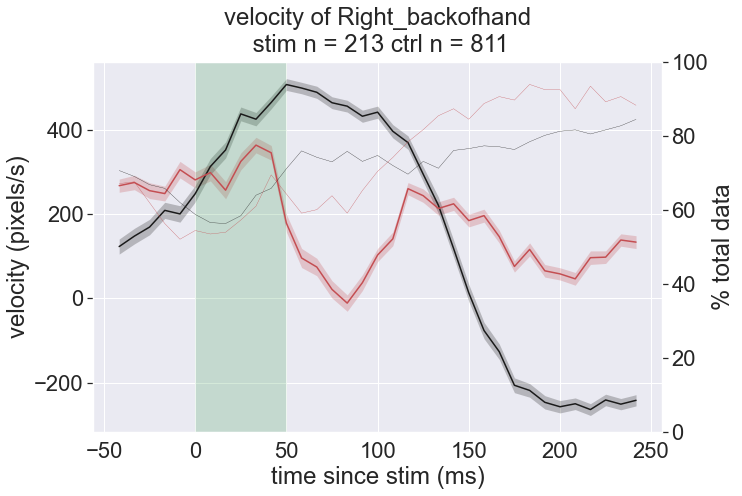

In [297]:
effector = 'Right_backofhand'; max_vel_limit = 1000
vel_df = reaches[reaches.velocity < max_vel_limit]
vel_df = vel_df[vel_df.velocity > -max_vel_limit]
plot_velocity(vel_df, limits, effector)
plt.savefig(plot_dir + animal + subfolder + '_velocity_' + effector + '.pdf')

# distance
Calculate a time-series containing the distance between two effectors tracked by DeepLabCut during reaching. The output is a pandas dataframe that contains distance information for reaches indexed by session and reach type. Then plot the distance over the time course of the reach. Thick line is average and shaded area is standard deviation

In [298]:
effector_1, effector_2 = 'R_Finger2','R_Finger4'

if do_distance == 1:
    dist = compute_distance(reaches, effector_1, effector_2)
    dist.to_hdf((clipped_dir + animal + '_' + str(limits[0]) + '_' + str(limits[1]) +
                 '_distance_' + effector_1 + "_" + effector_2 + '.h5'), key = 'dist_df', mode = 'w')
if do_distance == 0:
    root = Tk(); root.lift() 
    root.filename = filedialog.askopenfilename(initialdir=clipped_dir, title='Select Data')
    root.mainloop(); file_name = root.filename; dist = pd.read_hdf(file_name)

10 % finished calculating distance
20 % finished calculating distance
30 % finished calculating distance
40 % finished calculating distance
50 % finished calculating distance
60 % finished calculating distance
70 % finished calculating distance
80 % finished calculating distance
90 % finished calculating distance
100 % finished calculating distance


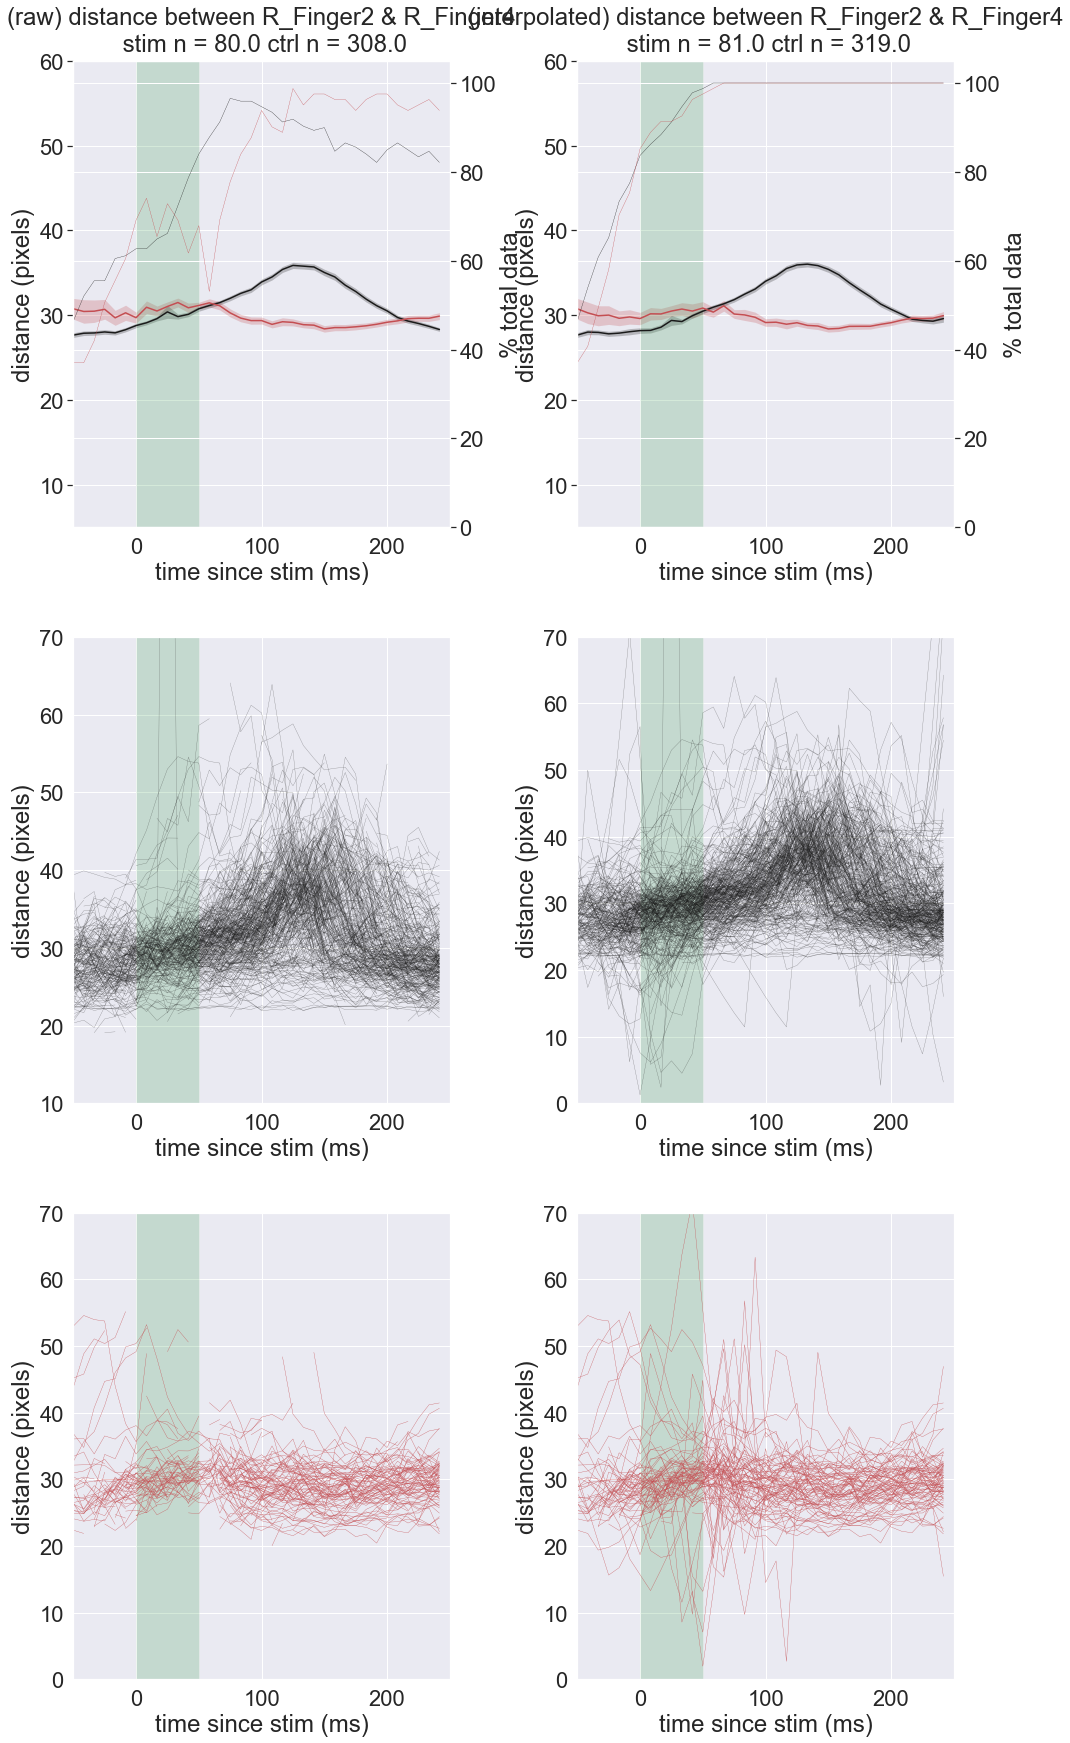

In [299]:
plot_distance(dist, limits, effector_1, effector_2)
plt.savefig(plot_dir + animal + subfolder + '_distance_' + effector_1 + '_' + effector_2 + '.pdf')

# merge velocity & distance
#### merge_df has velocity data from motive and distance between finger3/4

In [300]:
session_list = reaches.index.get_level_values(0).unique()
effector_list = reaches.index.get_level_values(1).unique()
effector = 'Right_backofhand'; max_vel_limit = 1000; counter = 0

for session in session_list:
    df = reaches.loc[(session, effector)]
    if counter == 0:
        velocity_df = pd.concat([df], keys=[session],
                            names=['session'], sort=True)
    else:
        temp = pd.concat([df], keys=[session],
                            names=['session'], sort=True)
        velocity_df = pd.concat([velocity_df, temp], sort=True)
    counter = counter + 1

trial_list = intersection(velocity_df.trial.unique(), dist.trial.unique())
velocity_df = velocity_df.loc[velocity_df['trial'].isin(trial_list)]
dist_df = dist.loc[dist['trial'].isin(trial_list)]
dist_df = dist_df.drop(['x', 'y', 'z', 'x_interp', 'y_interp', 'reach_type', 'trial', 'frame'], axis=1)

merge_df = pd.merge(dist_df, velocity_df, on=['session', 'clipped_index', 'index'], how='inner')
merge_df = merge_df.dropna(subset=['distance_interp', 'velocity_interp'])
merge_df = merge_df.astype({'distance_interp': 'float', 'velocity_interp': 'float'})

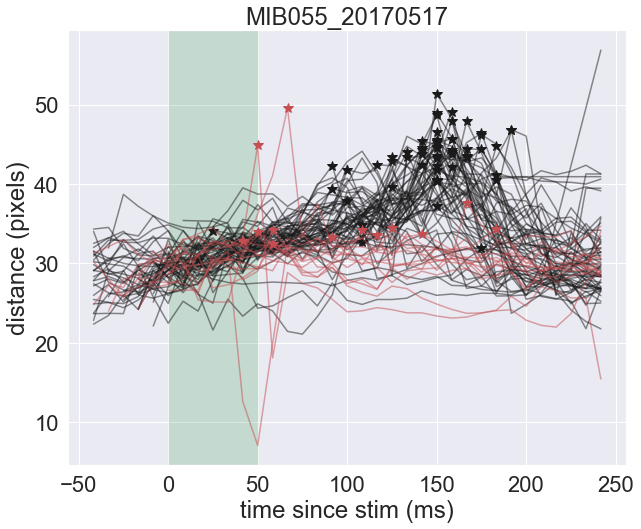

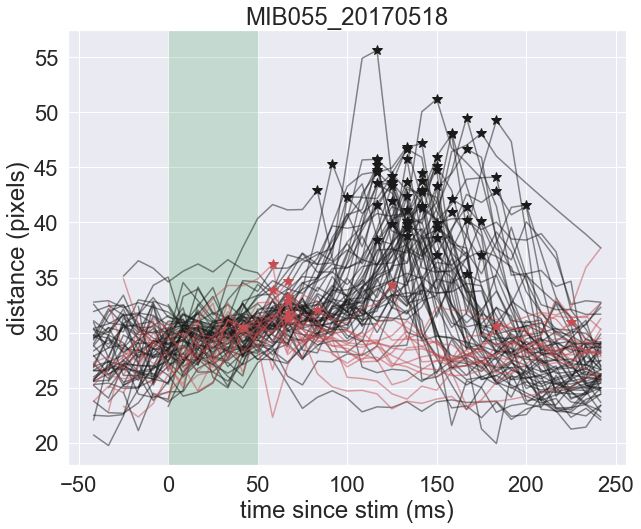

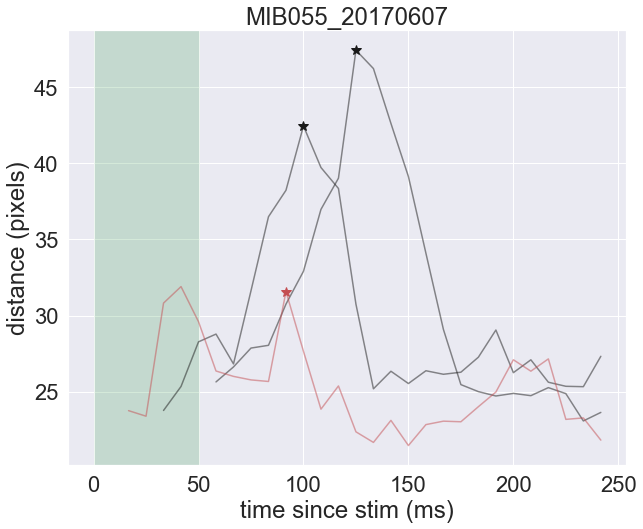

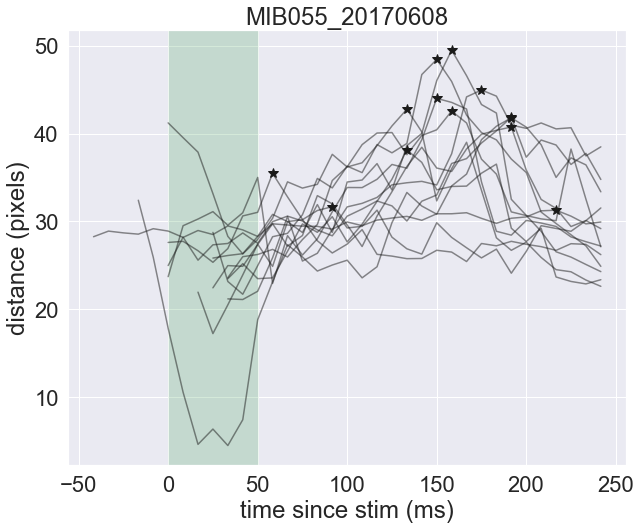

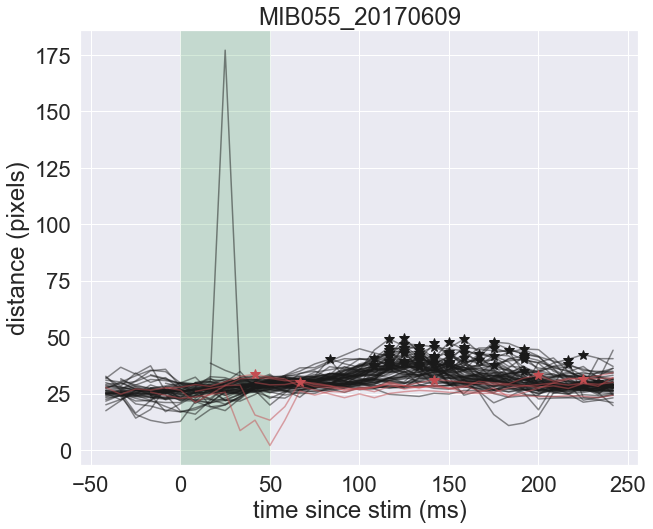

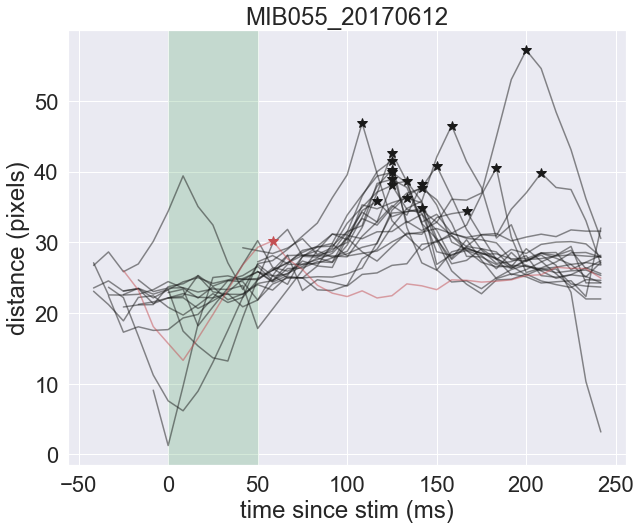

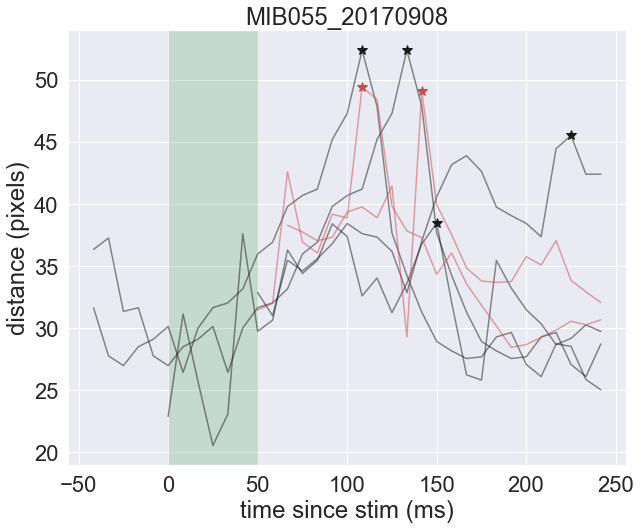

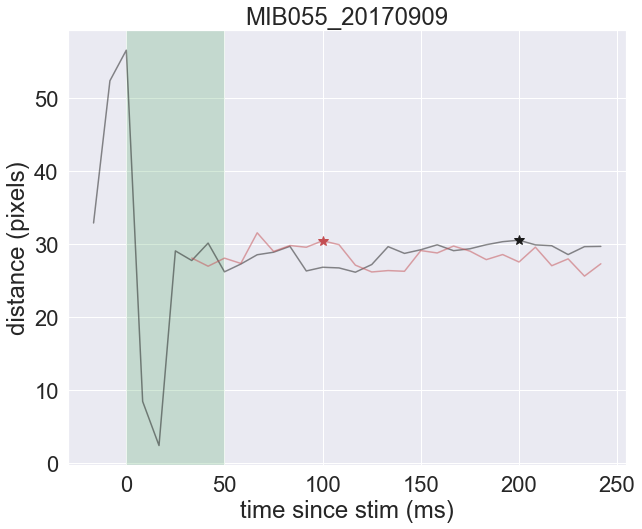

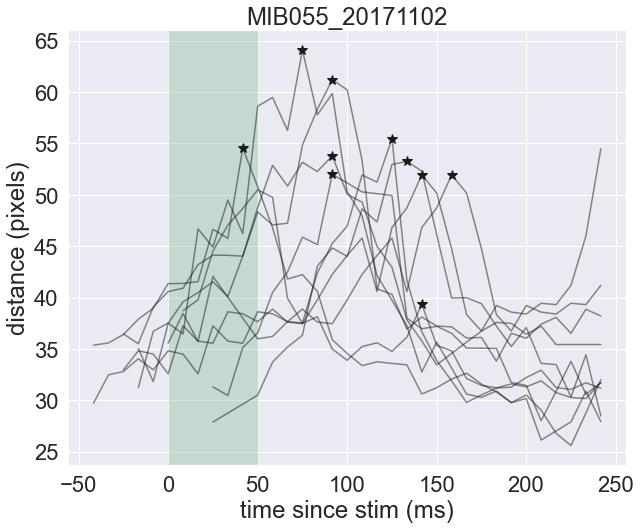

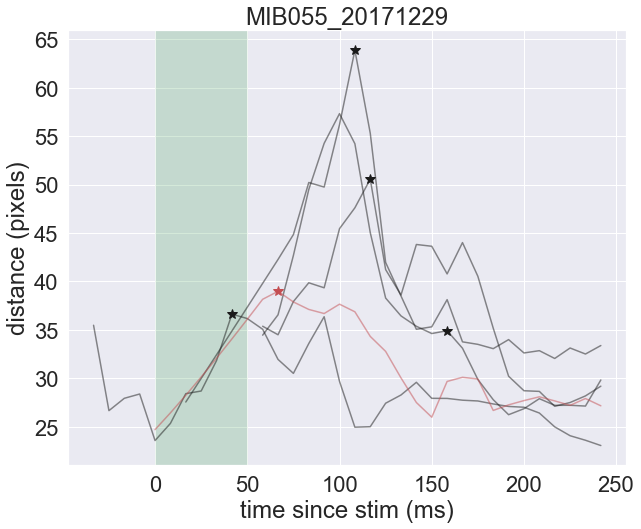

In [301]:
counter = 0; stim_frame = int(limits[0]/(1000/fps))
emptyNone = [None]*len(dist)
session_list = merge_df.index.get_level_values(0).unique()

df = pd.DataFrame({'session':emptyNone,'trial':emptyNone, 'reach_type':emptyNone,
                'open_t':emptyNone, 'max_dist_t':emptyNone, 'diff':emptyNone,
                'max_dist':emptyNone, 'max_x_t':emptyNone, 
                'max_vel':emptyNone, 'max_vel_t':emptyNone, 'vel_0_t': emptyNone})

for s in range(0, len(session_list)):

    session_df = merge_df.loc[session_list[s]]
    session_df = session_df.reset_index(0)
    
    trial_list = session_df.trial.unique()
    fig, ax1 = plt.subplots(1, figsize=(10, 8))
    ax1.set_title(session_list[s])
    ax1.set_xlabel('time since stim (ms)')
    ax1.set_ylabel('distance (pixels)')
    ax1.axvspan(0, 50, facecolor= 'g', alpha=0.25)

    for t in range(0,len(trial_list)):
        
        trial_df = session_df[session_df.trial == trial_list[t]]
        trial_df = trial_df.reset_index()
        trial_df = trial_df[stim_frame:len(trial_df)]
        
        if all(trial_df.x > 400) and all(trial_df.distance_interp < 70):  
        #if all(trial_df.distance_interp < 70):
            #baseline = trial_df.distance_interp[trial_df.clipped_index <= stim_frame]
            #open_threshold = baseline.mean() + 1*baseline.std()
            open_threshold = 8

            ## find x-peaks in every trial ##
            peaks, _ = find_peaks(trial_df.x, distance = 20)
            if len(peaks > 0):
                peaks_df = trial_df.iloc[peaks]
                p = 1;
                max_x_index = peaks_df.clipped_index[peaks[p-1]+stim_frame]
                #if len(peaks) == p:
                    #if trial_df.reach_type.unique() == 0:
                    #    ax1.plot(trial_df.clipped_index, trial_df.x, 'k', alpha=0.5)
                    #    ax1.plot(peaks_df.clipped_index[peaks[p-1]], 
                    #             peaks_df.x[peaks[p-1]], 'ko', markersize=10)
                    #elif trial_df.reach_type.unique() == 1:
                    #    ax1.plot(trial_df.clipped_index, trial_df.x, 'r', alpha=0.5)
                    #    ax1.plot(peaks_df.clipped_index[peaks[p-1]], 
                                 #peaks_df.x[peaks[p-1]], 'ro', markersize=10)
            
            else: max_x_index = None
                
                
            ## find velocity-peaks in every trial ##
            peaks, _ = find_peaks(trial_df.velocity_interp, distance = 20)
            
            if len(peaks > 0):
                
                peaks_df = trial_df.iloc[peaks]
                p = 1;
                max_vel_index = peaks_df.clipped_index[peaks[p-1]+stim_frame]
                max_vel = float(trial_df.velocity_interp[trial_df.clipped_index == max_vel_index])
                #if len(peaks) == p:
                    #if trial_df.reach_type.unique() == 0:
                        #sns.lineplot(ax = ax1, x = 'clipped_index', y = 'velocity', 
                        #         color = 'k', alpha=0.5, data = trial_df)
                        #ax1.plot(peaks_df.clipped_index[peaks[p-1]], 
                        #         peaks_df.x[peaks[p-1]], 'ko', markersize=10)
                    #elif trial_df.reach_type.unique() == 1:
                        #sns.lineplot(ax = ax1, x = 'clipped_index', y = 'velocity', 
                        #             color = 'r', alpha=0.5, data = trial_df)
                        #ax1.plot(peaks_df.clipped_index[peaks[p-1]], 
                        #         peaks_df.x[peaks[p-1]], 'ro', markersize=10)
                df.loc[counter][['max_vel_t', 'max_vel']] = (
                    [((max_vel_index-stim_frame)*(1000/fps)), max_vel])
                
            else: max_vel_index = None
                
            ## Find velocity == 0 after stim ##
            min_vel = trial_df.velocity_interp.min()
            min_vel_idx = trial_df.clipped_index[trial_df.velocity_interp == min_vel]
            if len(min_vel_idx > 1):
                min_vel_idx = min_vel_idx.iloc[0]
            velocity_temp = 0
            while min_vel <= 0:
                min_vel_idx = int(min_vel_idx) - 1
                min_vel = trial_df.velocity_interp[trial_df.clipped_index == min_vel_idx]
                if len(min_vel) == 0:
                    min_vel_idx = None
                    min_vel = 1
                else: 
                    min_vel = float(trial_df.velocity_interp[trial_df.clipped_index == min_vel_idx])
            if min_vel_idx is not None:
                vel_0_index =  min_vel_idx
                df.loc[counter][['vel_0_t']] = ((vel_0_index-stim_frame)*(1000/fps))
            else: df.loc[counter][['vel_0_t']] = None

            ## only look for hand opening after stim/threshold ##
            open_loc = trial_df.clipped_index[(trial_df.distance_interp > open_threshold) &
                                                    (trial_df.clipped_index > stim_frame)]
            
            peaks, _ = find_peaks(trial_df.distance_interp, distance = 20, height = 30)
            
            if len(open_loc) > 0 and len(peaks) > 0:

                open_index = open_loc.iloc[0]
                peaks_df = trial_df.iloc[peaks]
                p = 1;
                max_dist_index = peaks_df.clipped_index[peaks[p-1]+stim_frame]
                max_dist = float(trial_df.distance_interp[trial_df.clipped_index == max_dist_index])

                trial_plt = session_df[session_df.trial == trial_list[t]]
                if len(peaks) == p:
                    if trial_df.reach_type.unique() == 0:
                        #fig, ax1 = plt.subplots(1, figsize=(10, 8))
                        #ax1.set_title(session_list[s])
                        #ax1.set_xlabel('time since stim (ms)')
                        #ax1.set_ylabel('distance (pixels)')
                        #ax1.axvspan(0, 50, facecolor= 'g', alpha=0.25)
                        ax1.plot(((trial_plt.clipped_index)*1000/fps-50), trial_plt.distance_interp, 'k', alpha=0.5)
                        ax1.plot(((peaks_df.clipped_index[peaks[p-1]+stim_frame])*1000/fps-50),
                                peaks_df.distance_interp[peaks[p-1]+stim_frame], 'k*', markersize=10)
                        #plt.savefig(plot_dir + animal + subfolder + '_distance_ind_' + effector_1 + '_' + effector_2 + '_' + str(t) + '_.pdf')
                    elif trial_df.reach_type.unique() == 1:
                        #fig, ax1 = plt.subplots(1, figsize=(10, 8))
                        #ax1.set_title(session_list[s])
                        #ax1.set_xlabel('time since stim (ms)')
                        #ax1.set_ylabel('distance (pixels)')
                        #ax1.axvspan(0, 50, facecolor= 'g', alpha=0.25)
                        ax1.plot(((trial_plt.clipped_index)*1000/fps-50), trial_plt.distance_interp, 'r', alpha=0.5)
                        ax1.plot(((peaks_df.clipped_index[peaks[p-1]+stim_frame])*1000/fps-50),
                                 peaks_df.distance_interp[peaks[p-1]+stim_frame], 'r*', markersize=10)
                        #plt.savefig(plot_dir + animal + subfolder + '_distance_ind_' + effector_1 + '_' + effector_2 + '_' + str(t) + '_.pdf')

                df.loc[counter][['open_t', 'max_dist_t', 'max_dist']] = ([((open_index-stim_frame)*(1000/fps)), 
                     ((max_dist_index-stim_frame)*(1000/fps)), max_dist])
                
            df.loc[counter][['session', 'trial', 'reach_type']] = (
                [session_list[s], trial_list[t], int(trial_df.reach_type.unique())])
            if max_x_index is not None:
                df.loc[counter][['max_x_t', 'diff']] = (
                    [((max_x_index-stim_frame)*(1000/fps)),
                    ((max_x_index-max_dist_index)*(1000/fps))])
                
            counter = counter + 1
            plt.savefig(plot_dir + animal + subfolder + '_distance_ind' + str(s) + '_' + effector_1 + '_' + effector_2 + '.pdf')

df.dropna(how='all', inplace=True)
#df = df[df.max_vel < max_vel_limit]; df = df[df.max_vel > -max_vel_limit]
#df = df[df. vel_0_t > 30]

df = df.astype({'max_dist':float, 'open_t':float, 'max_dist_t':float, 'diff':float, 
                'max_x_t':float, 'reach_type':float, 'max_vel_t':float, 'max_vel':float, 
               'vel_0_t':float})

## Violin plots

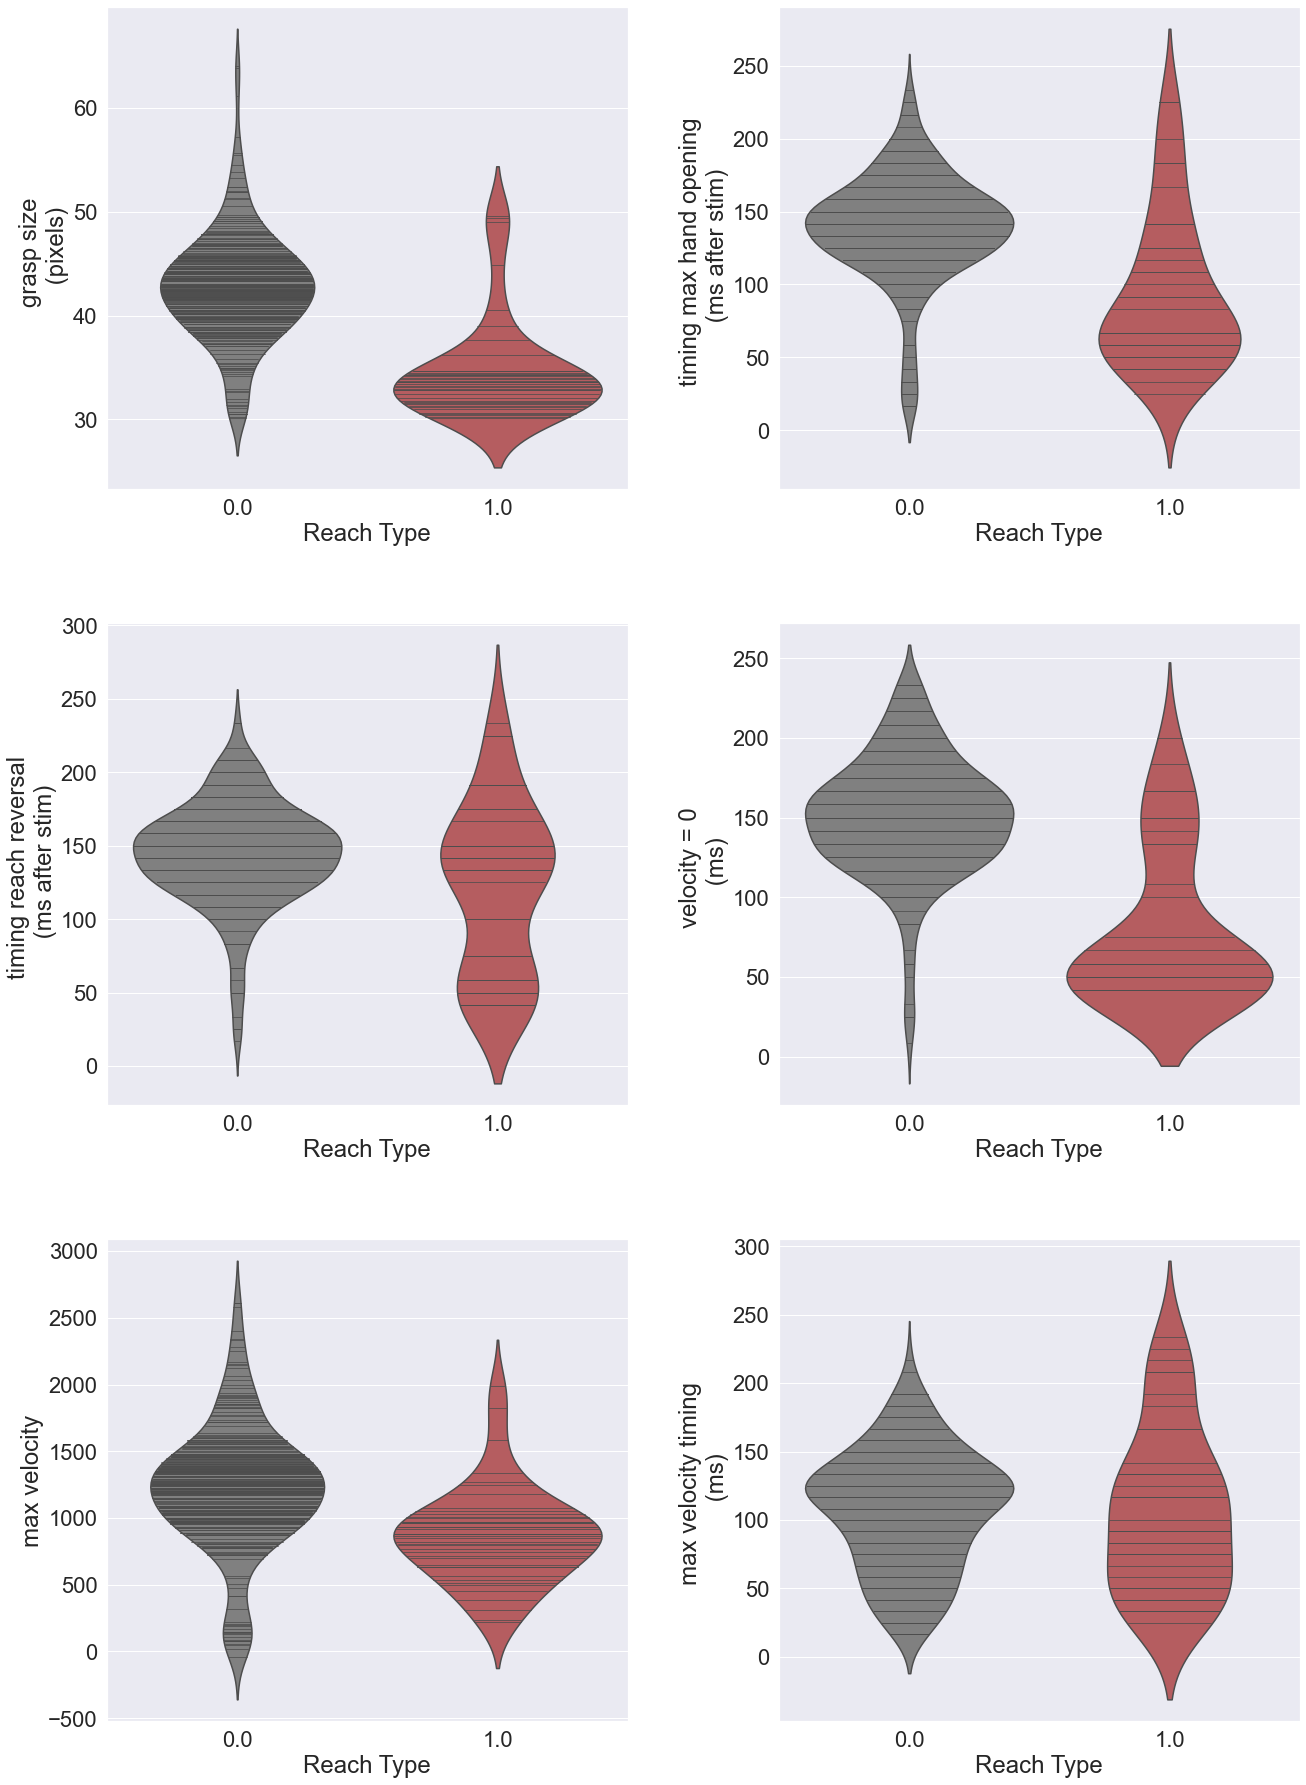

In [302]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 27))
fig.tight_layout(pad=4); sns.set(font_scale = 2); fnt_sz = 24
color_palette = {0 : "gray", 1: "r"}

sns.violinplot(ax = ax1, x = 'reach_type', y = 'max_dist', inner = 'stick', 
               palette = color_palette, data=df)
ax1.set_xlabel('Reach Type', fontsize = fnt_sz)
ax1.set_ylabel('grasp size \n (pixels)', fontsize = fnt_sz)

sns.violinplot(ax = ax2, x = 'reach_type', y = 'max_dist_t', inner = 'stick',
               palette = color_palette, data=df)

ax2.set_xlabel('Reach Type', fontsize = fnt_sz)
ax2.set_ylabel('timing max hand opening \n (ms after stim)', fontsize = fnt_sz)

sns.violinplot(ax = ax3, x = 'reach_type', y = 'max_x_t', inner = 'stick',
               palette = color_palette, data=df)

ax3.set_xlabel('Reach Type', fontsize = fnt_sz)
ax3.set_ylabel('timing reach reversal \n (ms after stim)', fontsize = fnt_sz)

sns.violinplot(ax = ax4, x = 'reach_type', y = 'vel_0_t', inner = 'stick',
               palette = color_palette, data=df)

ax4.set_xlabel('Reach Type', fontsize = fnt_sz)
ax4.set_ylabel('velocity = 0 \n (ms)', fontsize = fnt_sz)

sns.violinplot(ax = ax5, x = 'reach_type', y = 'max_vel', inner = 'stick',
               palette = color_palette, data=df)

ax5.set_xlabel('Reach Type', fontsize = fnt_sz)
ax5.set_ylabel('max velocity', fontsize = fnt_sz)

sns.violinplot(ax = ax6, x = 'reach_type', y = 'max_vel_t', inner = 'stick',
               palette = color_palette, data=df)

ax6.set_xlabel('Reach Type', fontsize = fnt_sz)
ax6.set_ylabel('max velocity timing \n (ms)', fontsize = fnt_sz)
plt.savefig(plot_dir + animal + subfolder + '_violin_plots_' + '.pdf')

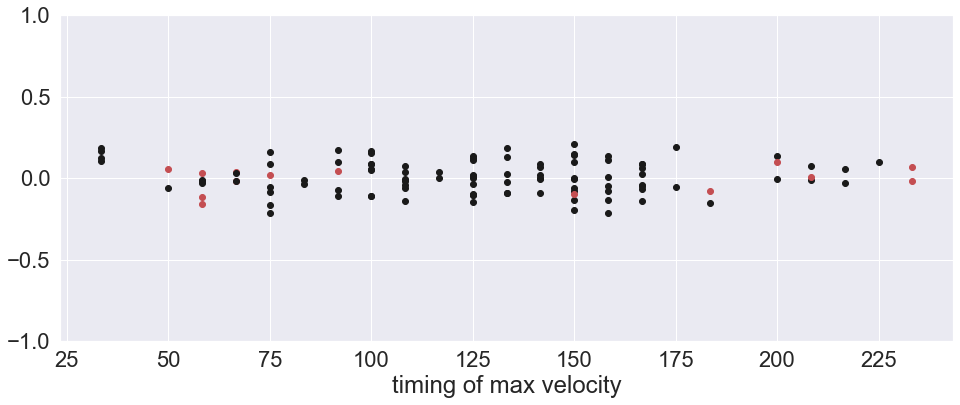

In [125]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.set_xlabel('timing of max velocity')

for t in df.trial:
    if int(df.reach_type[df.trial == t]) == 0:
        plt.plot(df.max_vel_t[df.trial == t], np.random.normal(0,.1,1), 'ko')
        ax1.set_ylim(-1,1)
        
    if int(df.reach_type[df.trial == t]) == 1:
        plt.plot(df.max_vel_t[df.trial == t], np.random.normal(0,.1,1), 'ro')
        ax1.set_ylim(-1,1)

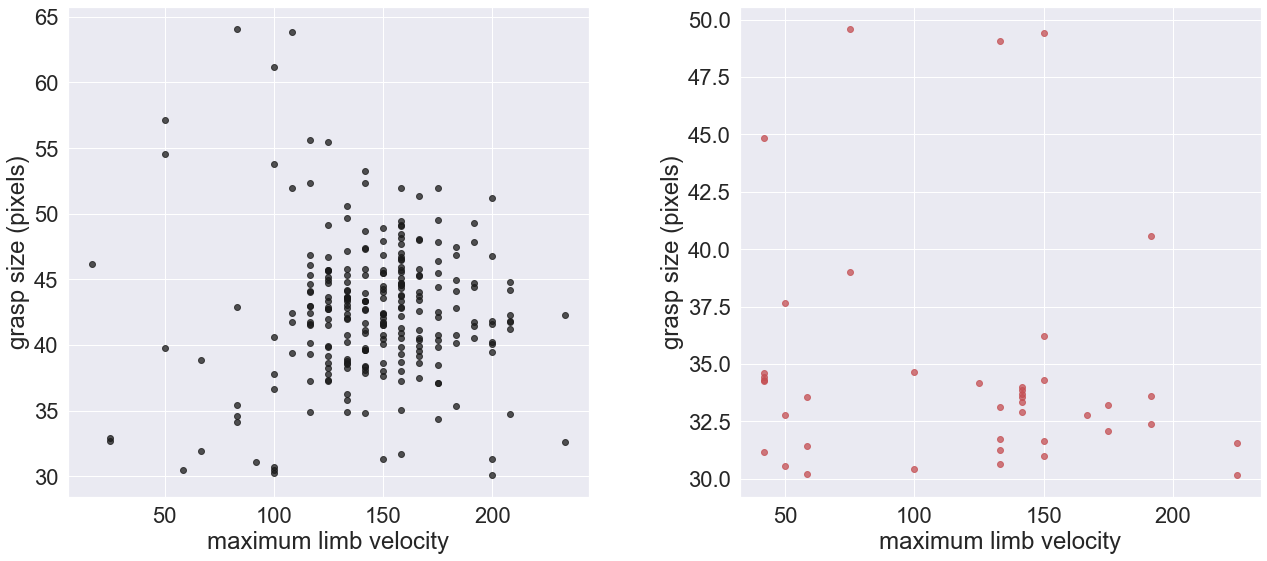

In [308]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
fig.tight_layout(pad = 4)

for t in df.trial:
    if int(df.reach_type[df.trial == t]) == 0:
        ax1.plot(df.max_x_t[df.trial == t], df.max_dist[df.trial == t], 'ko', alpha=0.75)
    if int(df.reach_type[df.trial == t]) == 1:
        ax2.plot(df.max_x_t[df.trial == t], df.max_dist[df.trial == t], 'ro', alpha=0.75)
    #line = range(-50,300)
    #ax1.plot(line, line, 'b', linewidth= 0.4); ax2.plot(line, line, 'b', linewidth=0.4)
    ax1.set_xlabel('maximum limb velocity'); ax2.set_xlabel('maximum limb velocity')
    ax1.set_ylabel('grasp size (pixels)'); ax2.set_ylabel('grasp size (pixels)')

plt.savefig(plot_dir + animal + subfolder + '_vel_0_t_vs_max_dist_t_' + '.pdf')

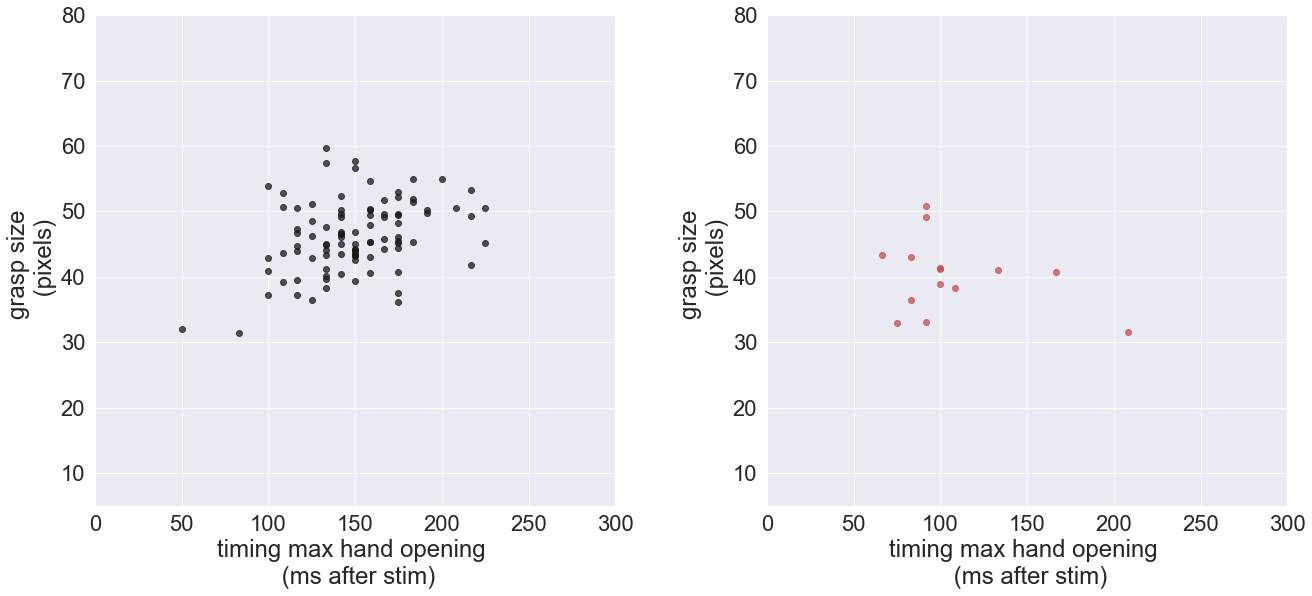

In [135]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
fig.tight_layout(pad = 4)

for t in df.trial:
    if int(df.reach_type[df.trial == t]) == 0:
        ax1.plot(df.max_dist_t[df.trial == t], df.max_dist[df.trial == t], 'ko', alpha=0.75)
    if int(df.reach_type[df.trial == t]) == 1:
        ax2.plot(df.max_dist_t[df.trial == t], df.max_dist[df.trial == t], 'ro', alpha=0.75)
        
    ax1.set_ylabel('grasp size \n (pixels)'); ax2.set_ylabel('grasp size \n (pixels)')
    ax1.set_xlabel('timing max hand opening \n (ms after stim)')
    ax2.set_xlabel('timing max hand opening \n (ms after stim)')
    ax1.set_xlim(0, 300); ax2.set_xlim(0,300)
    ax1.set_ylim(5,80); ax2.set_ylim(5,80)

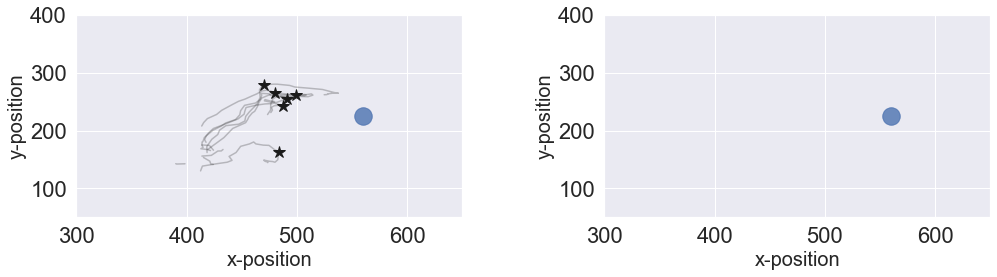

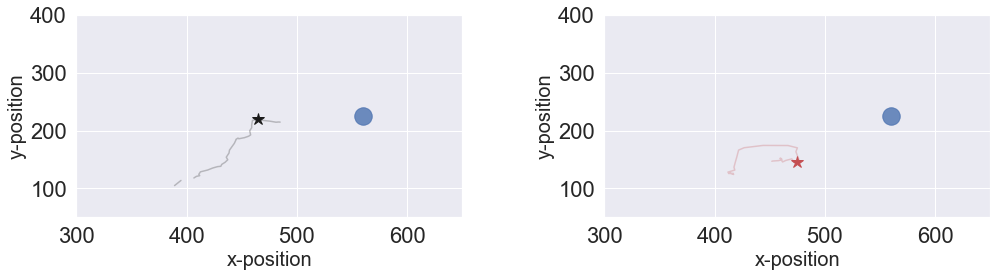

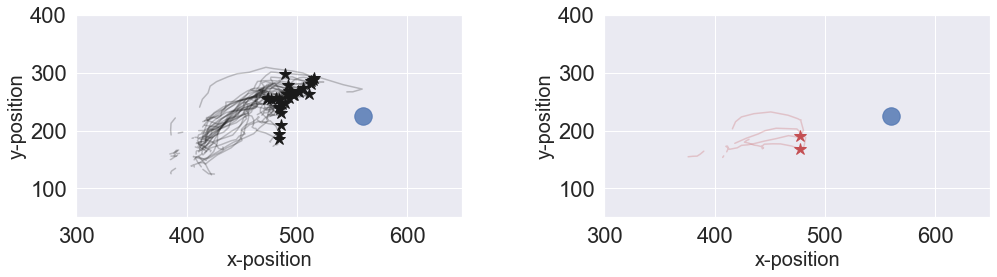

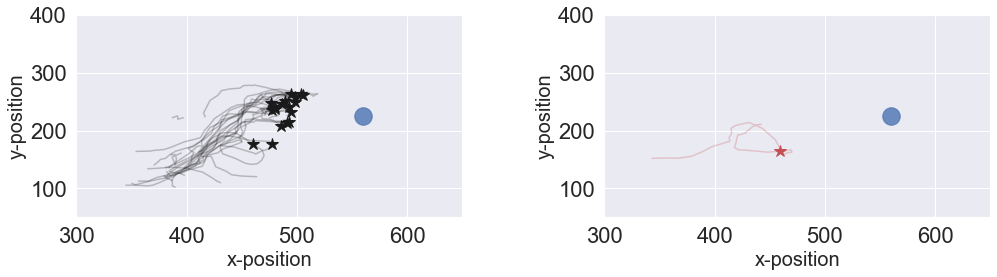

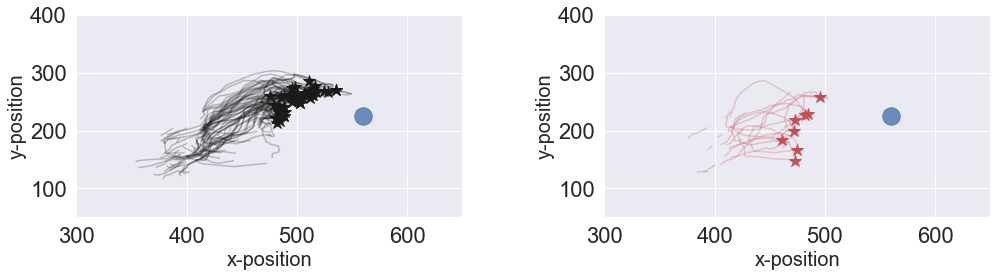

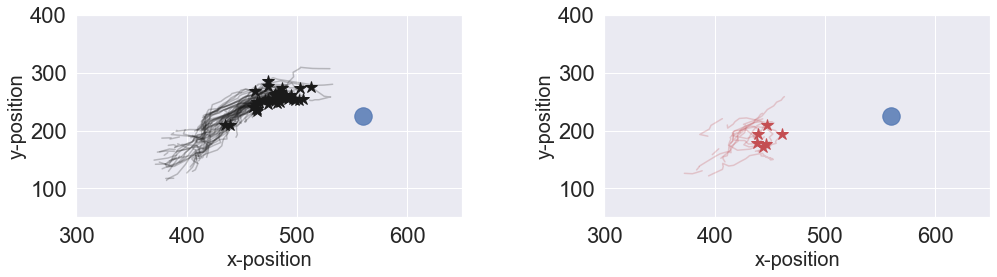

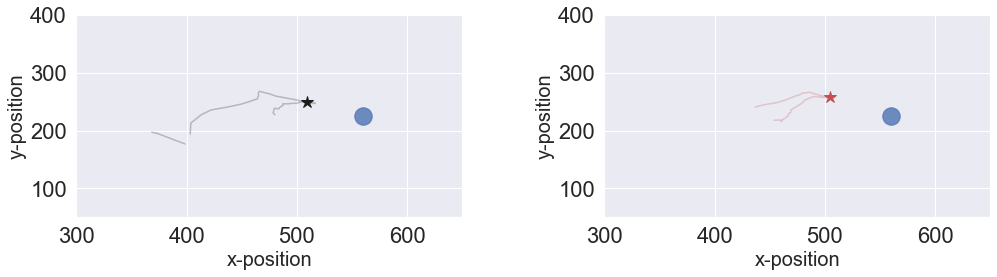

In [287]:
df.dropna(inplace=True)
session_list = df.session.unique()
trial_list = df.trial.unique()

for s in session_list:

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
    ax1.set_xlim(300,650); ax2.set_xlim(300,650)
    ax1.set_ylim(50,400); ax2.set_ylim(50,400)
    fig.tight_layout(pad=4)
    ax1.plot(560,225, 'b.', markersize=35, alpha=0.8)
    ax2.plot(560,225, 'b.', markersize=35, alpha=0.8)

    for t in trial_list:
        trial_df = reaches.loc[s, effector]
        trial_df = trial_df[trial_df.trial == t]
        if len(trial_df) > 0:
            event_df = df[df.trial == t]
            if int(trial_df.reach_type.unique()) == 0:
                ax1.plot('x', 'y', color = 'k', data = trial_df, alpha = .25)
                #ax1.plot(trial_df.loc[int((event_df.max_x_t)/(1000/fps)) + stim_frame].x, 
                         #trial_df.loc[int((event_df.max_x_t)/(1000/fps))+ stim_frame].y, 
                         #'k.', markersize = 12)
                ax1.plot(trial_df.loc[int((event_df.max_dist_t)/(1000/fps)) + stim_frame].x, 
                         trial_df.loc[int((event_df.max_dist_t)/(1000/fps))+ stim_frame].y, 
                         'k*', markersize = 12)
            if int(trial_df.reach_type.unique()) == 1:
                ax2.plot('x', 'y', color = 'r', data = trial_df, alpha = .25)
                #ax2.plot(trial_df.loc[int((event_df.max_x_t)/(1000/fps)) + stim_frame].x, 
                         #trial_df.loc[int((event_df.max_x_t)/(1000/fps))+ stim_frame].y, 
                         #'r.', markersize = 12)
                ax2.plot(trial_df.loc[int((event_df.max_dist_t)/(1000/fps)) + stim_frame].x, 
                         trial_df.loc[int((event_df.max_dist_t)/(1000/fps))+ stim_frame].y, 
                         'r*', markersize = 12)
            ax1.set_xlabel('x-position', fontsize=20); ax2.set_xlabel('x-position', fontsize=20)
            ax1.set_ylabel('y-position', fontsize=20); ax2.set_ylabel('y-position', fontsize=20)
            
            plt.savefig(plot_dir + animal + subfolder + str(s) + 'R_bhand_target' + '.pdf')
            

# X-Y Position
Plot the mean x-y position by stim vs. ctrl reaches

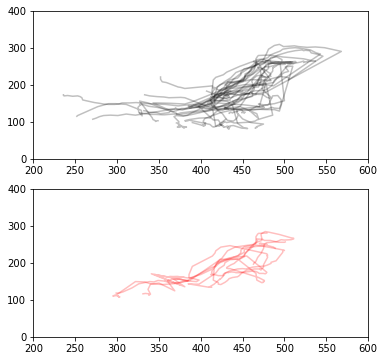

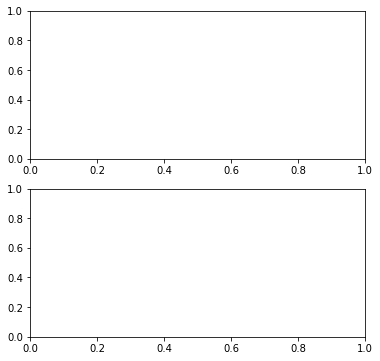

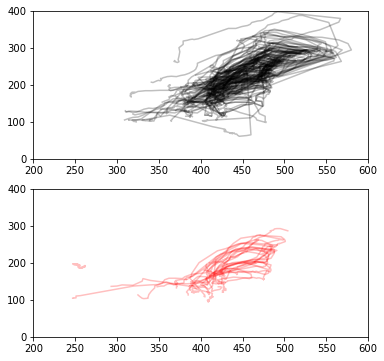

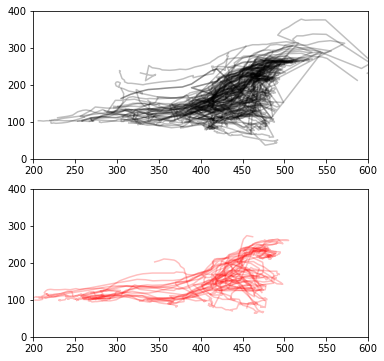

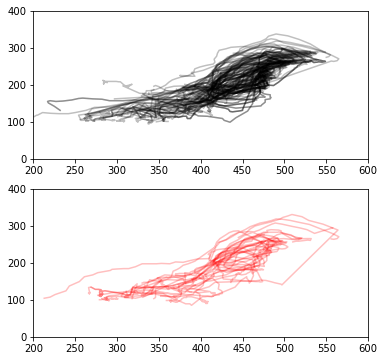

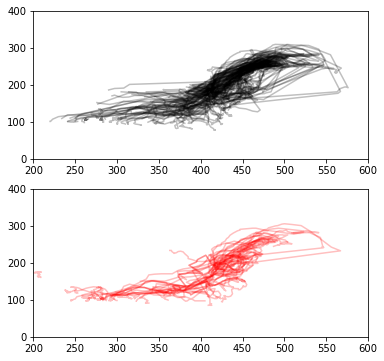

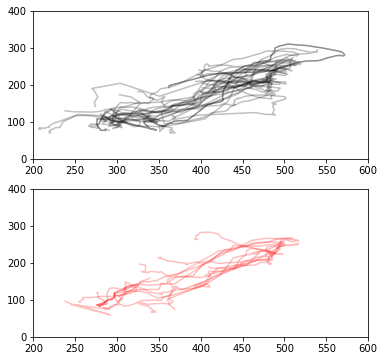

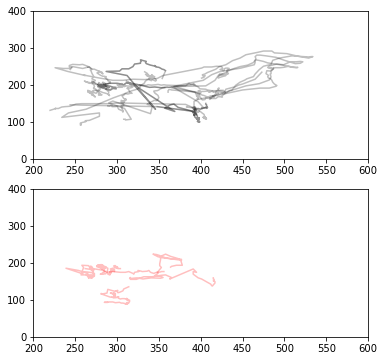

In [25]:
effector = 'Right_backofhand'
session_list = reaches.index.get_level_values(0).unique()
for s in range(0, len(session_list)):
    df = reaches.loc[session_list[s], effector]
    df = df.dropna(subset=['x', 'y', 'velocity'])
    df = df.astype({'x': 'int32', 'y': 'int32', 'velocity': 'float'})
    df = df.reset_index(0)
    df = df[(df.velocity < 3) & (df.frame > 0) & 
             (df.x > 200) & (df.y < 400)]
    #df = df[df.effector == 'Right_backofhand']
    #sns.lineplot(x='frame', y='velocity', hue='reach_type', data=df)

    fig, (ax1, ax2)= plt.subplots(2, figsize=(6,6))
    df_ctrl = df[df.reach_type == 0]
    trials = df_ctrl.trial.unique()

    for t in range(1,len(trials)):
        trial = df[df.trial == trials[t]]
        ax1.plot('x', 'y', color = 'black', data = trial, alpha = .25)
        ax1.set_xlim(200,600); ax1.set_ylim(0,400)

    df_stim = df[df.reach_type == 1]
    trials = df_stim.trial.unique()

    for t in range(1,len(trials)):
        trial = df_stim[df_stim.trial == trials[t]]
        ax2.plot('x', 'y', color = 'red', data = trial, alpha = .25)
        ax2.set_xlim(200,600); ax2.set_ylim(0,400)

# Trial-by-Trial 
Break animal data down by session, then perform trial-by-trial analyses

In [26]:
effector = 'Right_backofhand'
session_list = reaches.index.get_level_values(0).unique()

reaches_df = reaches.loc[session_list[2], effector]
reaches_df = reaches_df.dropna(subset=['x', 'y', 'velocity'])
reaches_df = reaches_df.astype({'x': 'int32', 'y': 'int32', 'velocity': 'float'})
reaches_df = reaches_df.reset_index(0)
reaches_df = reaches_df[(reaches_df.velocity < 3) & (reaches_df.frame > 0) &
             (reaches_df.x > 200) & (reaches_df.y < 400)]

trials = reaches_df.trial.unique()

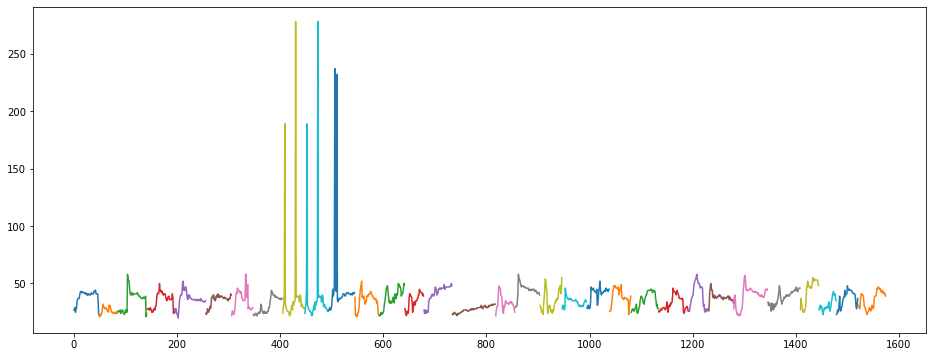

In [27]:
session_list = dist.index.get_level_values(0).unique()

dist_df = dist.loc[session_list[3]]
dist_df = dist_df.dropna(subset=['distance', 'distance_interp'])
dist_df = dist_df.astype({'distance': 'int32', 'distance_interp': 'int32'})
dist_df = dist_df.reset_index(0)

trials = dist_df.trial.unique()

fig, ax1 = plt.subplots(1, figsize=(16, 6))

for t in range(0,len(trials)):
    trial = dist_df[dist_df.trial == trials[t]]
    plt.plot(trial.distance)

In [322]:
session_list = dist.index.get_level_values(0).unique()
dist_df = dist.dropna(subset=['distance', 'distance_interp'])
dist_df = dist_df.mask(dist_df.eq('None')).dropna(subset=['distance', 'distance_interp'])
dist_df = dist_df.astype({'distance': 'int32', 'distance_interp': 'int32'})
dist_df = dist_df[dist_df.distance < 70]
counter = 0; stim_frame = 12
emptyNone = [None]*len(dist)

df = pd.DataFrame({'session':emptyNone,'trial':emptyNone, 'reach_type':emptyNone,
                'open_t':emptyNone, 'max_t':emptyNone, 'diff':emptyNone,
                'max_open':emptyNone, 'open_x':emptyNone, 'max_x':emptyNone,
                'open_y':emptyNone, 'max_y':emptyNone})

for s in range(0, len(session_list)):

    session_df = dist_df.loc[session_list[s]]
    session_df = session_df.reset_index(0)
    
    trial_list = session_df.trial.unique()
    
    for t in range(0,len(trial_list)):
        trial_df = session_df[session_df.trial == trial_list[t]]
        baseline = trial_df.distance[trial_df.clipped_index <= stim_frame]
        open_threshold = baseline.mean() + 2*baseline.std()
        #open_threshold = 35

        # find those events in the trial
        open_loc = trial_df.clipped_index[(trial_df.distance > open_threshold) & 
                                          (trial_df.clipped_index > stim_frame)]
        
        if len(open_loc) > 0:
        
            open_index = open_loc.iloc[0]
            max_open = trial_df.distance.max()
            max_index = int(trial_df.clipped_index[trial_df.distance == max_open].iloc[0]) 
            open_x = dist_df.loc[session_list[s], open_index]
            open_x = int(open_x[open_x.trial == trial_list[t]].x)
            max_x = dist_df.loc[session_list[s], max_index]
            max_x =int(max_x[max_x.trial == trial_list[t]].x)
            
            open_y = dist_df.loc[session_list[s], open_index]            
            open_y = int(open_y[open_y.trial == trial_list[t]].y)
            max_y = dist_df.loc[session_list[s], max_index]
            max_y = int(max_y[max_y.trial == trial_list[t]].y)
            
            df.loc[counter][['session', 'trial', 'reach_type']] = (
                [session_list[s], trial_list[t], int(trial_df.reach_type.unique())])
            df.loc[counter][['open_t', 'max_t', 'diff']] = (
                [((open_index-stim_frame)*(1000/fps)), ((max_index-stim_frame)*(1000/fps)), 
                ((max_index-stim_frame)*(1000/fps))-((open_index-stim_frame)*(1000/fps))])
            df.loc[counter][['max_open', 'open_x', 'max_x', 'open_y', 'max_y']] = (
                [max_open, open_x, max_x, open_y, max_y]) 

            
            counter = counter + 1
            
df = df.dropna()
df = df[df.max_x > 425]
df = df.astype({'max_open':int, 'open_t':int, 'max_t':int, 'diff':int, 
                'open_x':int, 'max_x':int, 'open_y':int, 'max_y':int})

Text(0.5, 0, 'Reach Type')

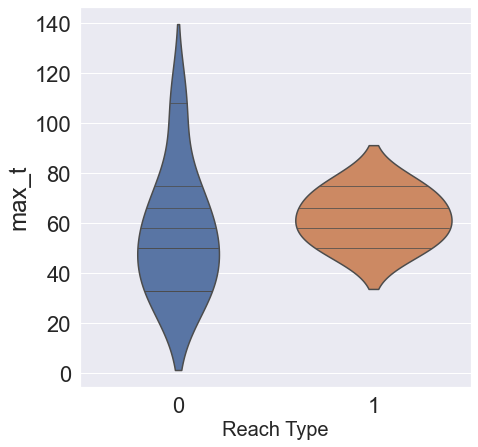

In [323]:
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.violinplot('reach_type', 'max_t', inner = 'stick', data=df)
ax.set_xlabel('Reach Type', fontsize=20)

#### 

### HINT that limb velocity is related to the size of hand opening.

Text(0, 0.5, 'x-loc of max distance')

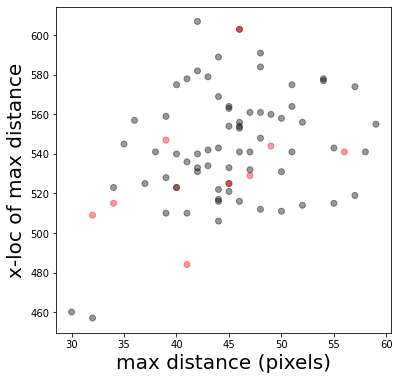

In [30]:
fig, ax = plt.subplots(1, figsize=(6, 6))
colors = {0:'black', 1:'red'}

plt.scatter('max_open', 'max_x', data=df, c= df['reach_type'].map(colors), alpha=0.4)
ax.set_xlabel('max distance (pixels)', fontsize=20)
ax.set_ylabel('x-loc of max distance', fontsize=20)

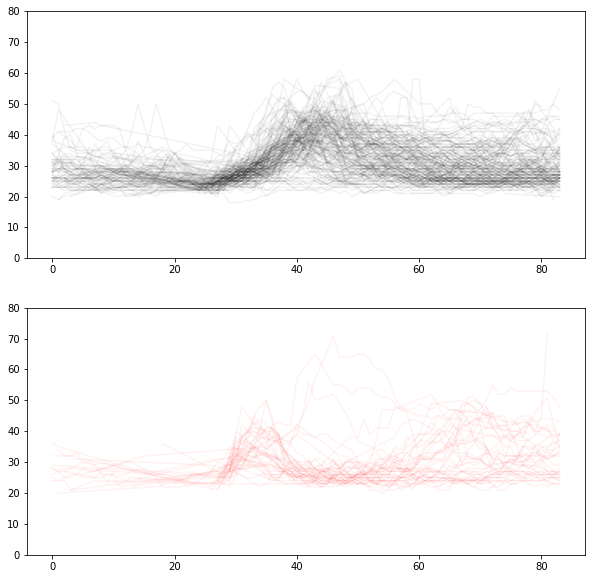

In [31]:
fig, (ax1, ax2)= plt.subplots(2, figsize=(10,10))
sesh_df = dist_df[dist_df.reach_type == 0]
trials = sesh_df.trial.unique()

for t in range(1,len(trials)):
    trial = sesh_df[sesh_df.trial == trials[t]]
    ax1.plot('frame', 'distance', color = 'black', data = trial, alpha = .05)
    ax1.set_ylim(0,80)

sesh_df = dist_df[dist_df.reach_type == 1]
trials = sesh_df.trial.unique()

for t in range(1,len(trials)):
    trial = sesh_df[sesh_df.trial == trials[t]]
    ax2.plot('frame', 'distance', color = 'red', data = trial, alpha = .05)
    ax2.set_ylim(0,80)

In [ ]:
effector = 'motive'
plot_position(reaches, limits, effector)
plt.savefig(plot_dir + animal + '_position_' + effector + '.pdf')

In [ ]:
def plot_position(input, limits, effector):
    
    input = reaches.copy()
    input = input.loc[effector]
    limits = [round(x/(1000/fps)) for x in limits]
    ctrl_color = 'k'; stim_color = 'r'; stim_line = 'g'; 
    avgLineThickness = 1.5; alphaShade = 0.25

    ctrl_trim = input[input.reach_type == 0]
    stim_trim = input[input.reach_type == 1]
    
    emptyList = list(np.repeat(0,sum(limits))); emptyRange = list(range(0,sum(limits)))
    empty_df = ({'frame':emptyRange,'time':emptyRange,'num':emptyList,
            'x':emptyList,'x_lower':emptyList,'x_upper':emptyList,
            'y':emptyList,'y_lower':emptyList,'y_upper':emptyList,
            'x_interp':emptyList,'x_lower_interp':emptyList,'x_upper_interp':emptyList,
            'y_interp':emptyList,'y_lower_interp':emptyList,'y_upper_interp':emptyList})
    
    ctrl_plot, stim_plot = pd.DataFrame(empty_df), pd.DataFrame(empty_df)

    for frame in ctrl_trim.frame.unique():
        
        df = ctrl_trim.loc[ctrl_trim.frame == frame]
        temp = df.loc[df.x > 0]
        temp_interp = df.loc[df.x_interp > 0]
        
        ctrl_plot.loc[frame, 'num'] = len(temp)
        ctrl_plot.loc[frame, 'x'] = temp.loc[:,'x'].mean()
        ctrl_plot.loc[frame, 'y'] = temp.loc[:,'y'].mean()
        ctrl_plot.loc[frame, 'x_interp'] = temp_interp.loc[:,'x_interp'].mean()
        ctrl_plot.loc[frame, 'y_interp'] = temp_interp.loc[:,'y_interp'].mean()
        ctrl_plot.loc[frame, 'x_lower'] = temp.loc[:,'x'].mean()-temp.loc[:,'x'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'x_upper']= temp.loc[:,'x'].mean()+temp.loc[:,'x'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'y_lower'] = temp.loc[:,'y'].mean()-temp.loc[:,'y'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'y_upper']= temp.loc[:,'y'].mean()+temp.loc[:,'y'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'x_lower_interp'] = temp_interp.loc[:,'x_interp'].mean()-temp_interp.loc[:,'x_interp'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'x_upper_interp']= temp_interp.loc[:,'x_interp'].mean()+temp_interp.loc[:,'x_interp'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'y_lower_interp'] = temp_interp.loc[:,'y_interp'].mean()-temp_interp.loc[:,'y_interp'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'y_upper_interp']= temp_interp.loc[:,'y_interp'].mean()+temp_interp.loc[:,'y_interp'].std()/((ctrl_plot.num[frame])**0.5)
        ctrl_plot.loc[frame, 'time']= 8.3333*(frame-limits[0])

    for frame in stim_trim.frame.unique():
        
        df = stim_trim.loc[stim_trim.frame == frame]
        temp = df.loc[df.x > 0]
        temp_interp = df.loc[df.x_interp > 0]
        
        stim_plot.loc[frame, 'num'] = len(temp)
        stim_plot.loc[frame, 'x'] = temp.loc[:,'x'].mean()
        stim_plot.loc[frame, 'y'] = temp.loc[:,'y'].mean()
        stim_plot.loc[frame, 'x_interp'] = temp_interp.loc[:,'x_interp'].mean()
        stim_plot.loc[frame, 'y_interp'] = temp_interp.loc[:,'y_interp'].mean()
        stim_plot.loc[frame, 'x_lower'] = temp.loc[:,'x'].mean()-temp.loc[:,'x'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'x_upper']= temp.loc[:,'x'].mean()+temp.loc[:,'x'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'y_lower'] = temp.loc[:,'y'].mean()-temp.loc[:,'y'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'y_upper']= temp.loc[:,'y'].mean()+temp.loc[:,'y'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'x_lower_interp'] = temp_interp.loc[:,'x_interp'].mean()-temp_interp.loc[:,'x_interp'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'x_upper_interp']= temp_interp.loc[:,'x_interp'].mean()+temp_interp.loc[:,'x_interp'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'y_lower_interp'] = temp_interp.loc[:,'y_interp'].mean()-temp_interp.loc[:,'y_interp'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'y_upper_interp']= temp_interp.loc[:,'y_interp'].mean()+temp_interp.loc[:,'y_interp'].std()/((ctrl_plot.num[frame])**0.5)
        stim_plot.loc[frame, 'time']= 8.3333*(frame-limits[0])

    # position plot
    fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3,2, figsize=(16,12))

    ax1.axvline(x=0, c = stim_line, lw=3, alpha=0.5)
    ax2.axvline(x=0, c = stim_line, lw=3, alpha=0.5)
    ax4.axvline(x=0, c = stim_line, lw=3, alpha=0.5)
    ax5.axvline(x=0, c = stim_line, lw=3, alpha=0.5)

    ax1.set_xlabel('time since stim (ms)'); ax2.set_xlabel('time since stim (ms)')
    ax3.set_xlabel('x-position'); ax6.set_xlabel('x-position')
    ax4.set_xlabel('time since stim (ms)'); ax5.set_xlabel('time since stim (ms)')

    ax1.set_ylabel('x-position'); ax2.set_ylabel('y-position')
    ax3.set_ylabel('y-position'); ax4.set_ylabel('x-position')
    ax5.set_ylabel('y-position'); ax6.set_ylabel('y-position')

    ax1.plot('time', 'x', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax1.plot('time', 'x', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax2.plot('time', 'y', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax2.plot('time', 'y', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax3.plot('x', 'y', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax3.plot('x', 'y', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax4.plot('time', 'x_interp', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax4.plot('time', 'x_interp', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax5.plot('time', 'y_interp', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax5.plot('time', 'y_interp', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax6.plot('x_interp', 'y_interp', data=ctrl_plot, color=ctrl_color, linewidth=avgLineThickness)
    ax6.plot('x_interp', 'y_interp', data=stim_plot, color=stim_color, linewidth=avgLineThickness)

    ax1.fill_between(stim_plot.time, stim_plot.x_lower, 
                     stim_plot.x_upper, color=stim_color, alpha=alphaShade, lw=0)
    ax1.fill_between(ctrl_plot.time, ctrl_plot.x_lower, 
                     ctrl_plot.x_upper, color=ctrl_color, alpha=alphaShade, lw=0)

    ax2.fill_between(stim_plot.time, stim_plot.y_lower, 
                     stim_plot.y_upper, color=stim_color, alpha=alphaShade, lw=0)
    ax2.fill_between(ctrl_plot.time, ctrl_plot.y_lower, 
                     ctrl_plot.y_upper, color=ctrl_color, alpha=alphaShade, lw=0)

    ax4.fill_between(stim_plot.time, stim_plot.x_lower_interp, 
                     stim_plot.x_upper_interp, color=stim_color, alpha=alphaShade, lw=0)
    ax4.fill_between(ctrl_plot.time, ctrl_plot.x_lower_interp, 
                     ctrl_plot.x_upper_interp, color=ctrl_color, alpha=alphaShade, lw=0)

    ax5.fill_between(stim_plot.time, stim_plot.y_lower_interp, 
                     stim_plot.y_upper_interp, color=stim_color, alpha=alphaShade, lw=0)
    ax5.fill_between(ctrl_plot.time, ctrl_plot.y_lower_interp, 
                     ctrl_plot.y_upper_interp, color=ctrl_color, alpha=alphaShade, lw=0)

    ax1.set_title(('Position ' + effector), pad=20)
    
    ### If plotting each individual trace, then this code runs instead of the above code.
    
    return

In [ ]:
min_reaches = 10
sessions = dist.index.get_level_values(0).unique()
for sesh in sessions:
    dist_sesh = dist.loc[sesh]
    if ((len(dist_sesh[dist_sesh.reach_type == 0].trial.unique()) >= min_reaches) and
        (len(dist_sesh[dist_sesh.reach_type == 1].trial.unique()) >= min_reaches)):
        print(sesh)
        plot_distance(dist_sesh, limits[0], 300, ef1, ef2, dirs[4])
    else:
        if((len(dist_sesh[dist_sesh.reach_type == 0].trial.unique()) < min_reaches) and
           (len(dist_sesh[dist_sesh.reach_type == 1].trial.unique()) >= min_reaches)):  
            print('not enough control reaches')
        elif((len(dist_sesh[dist_sesh.reach_type == 0].trial.unique()) >= min_reaches) and
           (len(dist_sesh[dist_sesh.reach_type == 1].trial.unique()) < min_reaches)):  
            print('not enough stim reaches')
        elif((len(dist_sesh[dist_sesh.reach_type == 0].trial.unique()) < min_reaches) and
           (len(dist_sesh[dist_sesh.reach_type == 1].trial.unique()) < min_reaches)):  
            print('not enough of both control and stim reaches')
            

In [52]:
def maxmin(dist_sesh, speed_motive_sesh):
    
    t=0
    trials_0 = dist_sesh.trial.unique()
    trials_1 = speed_motive_sesh.trial.unique()
    trials = intersection(trials_0, trials_1)
    
    for trial in trials:
        
        trial_df = dist_sesh[['reach_type', 'trial', 'frame', 'distance_interp']]
        trial_df = trial_df[trial_df.trial==trial]
        trial_df = trial_df[trial_df.frame > 100/8.33333 + 2]
        trial_df = trial_df[trial_df.frame < 350/8.33333 + 2]
        trial_dist = trial_df.loc[:, 'distance_interp']
        trial_dist = trial_dist.replace({None:np.nan})
            
        trial_speed = speed_motive_sesh[['trial', 'frame', 'velocity_interp']]
        trial_speed = trial_speed[trial_speed.trial==trial]
        trial_speed = trial_speed[trial_speed.frame > 100/8.33333 + 2]
        trial_speed = trial_speed[trial_speed.frame < 350/8.33333 + 2]
        trial_speed = trial_speed.loc[:, 'velocity_interp']
        trial_speed = trial_speed.replace({None:np.nan})
            
        if((sum(pd.isna(trial_dist)) < 15) and (sum(pd.isna(trial_speed)) < 15)):
            trial_df = pd.DataFrame(trial_df.reset_index().loc[0]).T
            trial_df = trial_df.drop(['distance_interp', 'clipped_index'], axis=1)
            trial_df['max_trial_dist'] = max(trial_dist[trial_dist.notnull()])
            #trial_df['max_trial_dist'] = trial_dist.index[trial_dist == max(trial_dist[trial_dist.notnull()])][0]
            trial_df['speed_diff'] = max(trial_speed[trial_speed.notnull()]) - min(trial_speed[trial_speed.notnull()])
            trial_speed = trial_speed.reset_index()
            #trial_df['max_trial_speed'] = trial_speed.velocity_interp[2]
            
        else:
            trial_df = pd.DataFrame(trial_df.reset_index().loc[0]).T
            trial_df = trial_df.drop(['distance_interp', 'clipped_index'], axis=1)
            trial_df['max_trial_dist'] = np.nan
            trial_df['speed_diff'] = np.nan

        # concatenate trial dataframes
        t=t+1
        if t == 1:
            session_df = pd.concat([trial_df], sort=True)
        elif t > 1:
            temp = pd.concat([trial_df], sort=True)
            concat = [session_df, temp]
            session_df = pd.concat(concat, sort=True)
                
    return(session_df)

In [30]:
vel_ctrl = np.array(list(max_vel[max_vel.reach_type == 0].maximum))
vel_stim = np.array(list(max_vel[max_vel.reach_type == 1].maximum))
                    
dist_ctrl = np.array(list(max_distance[max_distance.reach_type == 0].maximum))
dist_stim = np.array(list(max_distance[max_distance.reach_type == 1].maximum))

print('ctrl max velocity= ' + str(vel_ctrl.mean()))
print('stim max velocity= ' + str(vel_stim.mean()))
print(stats.ttest_ind(vel_ctrl,vel_stim, equal_var = False))
print('ctrl max distance= ' + str(dist_ctrl.mean()))
print('stim max distance= ' + str(dist_stim.mean()))
print(stats.ttest_ind(dist_ctrl,dist_stim, equal_var = False))

vel_ctrl = np.array(list(max_vel[max_vel.reach_type == 0].maximum_idx))
vel_stim = np.array(list(max_vel[max_vel.reach_type == 1].maximum_idx))
                    
dist_ctrl = np.array(list(max_distance[max_distance.reach_type == 0].maximum_idx))
dist_stim = np.array(list(max_distance[max_distance.reach_type == 1].maximum_idx))

print('ctrl max velocity timing= ' + str(round((vel_ctrl.mean()*8.333 - limits[0]), 0)) + ' ms after threshold/stim')
print('stim max velocity timing= ' + str(round((vel_stim.mean()*8.333 - limits[0]), 0)) + ' ms after threshold/stim')
print(stats.ttest_ind(vel_ctrl,vel_stim, equal_var = False))
print('ctrl max distance timing= ' + str(round((dist_ctrl.mean()*8.333 - limits[0]), 0)) + ' ms after threshold/stim')
print('stim max distance timing= ' + str(round((dist_stim.mean()*8.333 - limits[0]), 0)) + ' ms after threshold/stim')
print(stats.ttest_ind(dist_ctrl,dist_stim, equal_var = False))


NameError: name 'max_vel' is not defined